# 環境

## 掛接雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 顯示顯卡

In [ ]:
gpu_info = !nvidia-smi 
gpu_info = '\n'.join(gpu_info) 
if gpu_info.find('failed') >= 0: 
    print('Not connected to a GPU') 
else: 
    print(gpu_info)

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 前置準備

## **Mnist Database** (Modified National Institute of Standards and Technology database)
[LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.](https://ieeexplore.ieee.org/abstract/document/726791/?casa_token=o-y15B9yALIAAAAA:EHgg42ifXvC0q1_zyhOnTy8T6BteKwFD-0l39ijWGJiytFIVvNzIed-40s67Jqio2R6Jc5o)

![image.png](https://i.imgur.com/JJZBybv.png)

60,000 training images and 10,000 testing images.

Collected from American Census Bureau employees and American high school students.

Normalized to 28x28 pixel.



### **[Augmentation Skills in Pytorch](https://pytorch.org/vision/stable/transforms.html)**

增加資料多樣性，以彌補
* 資料量不足
* 模型過度擬合(overfitting)

增強模型的辨識能力

常見的augmentation skills: 旋轉、翻轉、平移、縮放......

**記得:** 不要盲目地使用，選擇適合該資料集的技巧

![image.png](https://i.imgur.com/Up0J2TF.png)


## 匯入訓練資料

In [ ]:
BATCH_SIZE = 32

# transformation
transform = transforms.Compose(
    [transforms.ToTensor()])

# apply augmentation skills
# size = (5,5)
# transform = transforms.Compose(
#     [transforms.CenterCrop(size),
#     transforms.RandomGrayscale(p=0.9),
#     transforms.ToTensor()])

# prepare training dataset
trainset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/GSDC/train_data', train=True, download=True, transform=transform)
train_subset, val_subset = torch.utils.data.random_split(trainset, [48000, 12000], generator=torch.Generator().manual_seed(1))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# prepare testing dataset
testset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/GSDC/test_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2) #記得這裡的BS是1, 後面才會一張張呈現成果

In [ ]:
print(len(train_subset))
print(len(val_subset))
print(len(testset))

48000
12000
10000


##顯示訓練資料

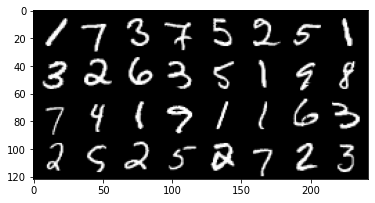

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# show the images
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # from (C,W,H) to (W,H,C) 

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

torch.Size([60000, 28, 28])
torch.Size([60000])


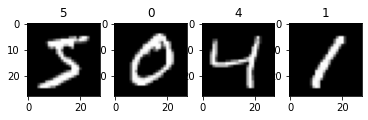

In [ ]:
print(trainset.data.size())
print(trainset.targets.size())
# plt.ion()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(trainset.data[i].numpy(), cmap = 'gray')
  plt.title('%i' % trainset.targets[i])
  # plt.pause(0.5)
plt.show()

## ****補充:** 影像處理
![image.png](https://i.imgur.com/TrsZQZH.png)

### [OpenCV imread](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html)

OpenCV(Open Source Computer Vision Library) 是由Intel發起建立的跨平台電腦視覺庫，可以和C++、Java、Python等語言搭配撰寫

cv.imread(	filename[, flags]	) -> retval

* In the case of color images, the decoded images will have the channels stored in $\color{blue}{B}$ $\color{green}{G}$ $\color{red}{R}$ order.

### [Matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
matplotlib.pyplot.imshow(X, **cmap**=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)

in $\color{red}{R}$ $\color{green}{G}$ $\color{blue}{B}$ order

Parameters:
Xarray-like or PIL image
* (M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. See parameters norm, cmap, vmin, vmax.

* (M, N, 3): an image with RGB values(0-1 float or 0-255 int).

* (M, N, 4): an image with RGBA values(0-1 float or 0-255 int), i.e. including transparency



## ****補充:** 從自己的雲端匯入資料
### [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset) (Kaggle)

![image.png](https://i.imgur.com/XS1oH7i.png)

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. Contents of this dataset:
* Number of categories: 120
* Number of images: 20,580
* Annotations: Class labels, Bounding boxes

In [ ]:
from torchvision import transforms, datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/stanford_dogs/stanfor_dogs/train/', transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

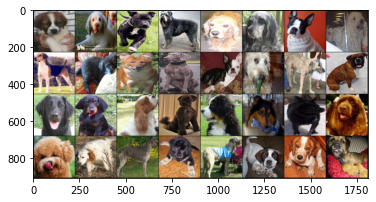

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# show the images
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # from (C,W,H) to (W,H,C)

## get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

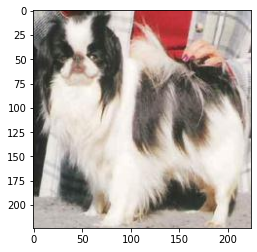

In [ ]:
# 讀單張影像
import cv2

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/stanford_dogs/stanfor_dogs/test/1.jpg")

# show the image in cv
# from google.colab.patches import cv2_imshow # cv2的imshow無法直接在colab上使用
# cv2_imshow(image)

# show the image in plt
image = image[:,:,::-1]
plt.imshow(image)
plt.show()

# 建立CNN [torch.nn(nn)](https://pytorch.org/docs/stable/nn.html)

In [ ]:
# Create your CNN model
class CNN(nn.Module):
    # Constructor
    def __init__(self, num_classes=10): # number 0~9
        super(CNN, self).__init__()
        
        # Our images are Gray-level(single channel), so input channels = 1. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 28x28 image tensors will be pooled twice with a kernel size of 2. 28/2/2 is 7.
        # So our feature tensors are now 7 x 7, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to the probability for each class
        self.fc = nn.Linear(in_features=7 * 7 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 7 * 7 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)

## model summary

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)
summary(model, (1, 28, 28), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 12, 28, 28]             120
         MaxPool2d-2           [32, 12, 14, 14]               0
            Conv2d-3           [32, 12, 14, 14]           1,308
         MaxPool2d-4             [32, 12, 7, 7]               0
            Conv2d-5             [32, 24, 7, 7]           2,616
         Dropout2d-6             [32, 24, 7, 7]               0
            Linear-7                   [32, 10]          11,770
Total params: 15,814
Trainable params: 15,814
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 4.17
Params size (MB): 0.06
Estimated Total Size (MB): 4.32
----------------------------------------------------------------


## ****補充:** Using Avaliable/Pretrain Model

### [Pytorch avaliable/pretrain models](https://pytorch.org/vision/stable/models.html)

![image.png](https://i.imgur.com/0Op6pYU.png)
![image.png](https://i.imgur.com/wgoPivd.png)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights) # 也可選擇不要用pretrained weight -> model = resnet50()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# 開始訓練

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# 超參數設定
learning_rate = 0.001
num_epochs = 3
# 優化器
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  

In [ ]:
model_loss={'train':[], 'val':[]}
model_acc={'train':[], 'val':[]}

def train(model, trainLoader, valLoader, optimizer, criterion, epochs):
    model.train()
    testAccuracy = 0
    bestModel = model
    for i in range(epochs):
        totalLoss = 0
        accuracy = 0
        count = 0
        for x, label in trainLoader:
            x = x.to(device)
            label = label.to(device, dtype=torch.long)
            optimizer.zero_grad() # 清空前一次的gradient
            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            # Otherwise, it will have old information from a previous iteration
            
            output = model(x) # 把images傳入model進行forward propagation
            loss = criterion(output, label)
            _, predicted = torch.max(output.data, 1)
            count += len(x)
            loss.backward() # 根據loss進行back propagation，計算gradient
            optimizer.step() # 做gradient descent
            accuracy += (predicted == label).sum().item()
            totalLoss += loss.item()*len(label)
        print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f'\
          %(i, totalLoss/count, accuracy/count))    
        model_loss['train'].append(totalLoss/count)
        model_acc['train'].append(accuracy/count)
        
        # 每幾個epoch存一次
        if (i % 1 == 0): 
            tmpAccuracy = val(model, valLoader, criterion, i)
            if (tmpAccuracy > testAccuracy):
                testAccuracy = tmpAccuracy
                bestModel = model
                epoch = i
                torch.save(bestModel, "/content/drive/MyDrive/Colab Notebooks/GSDC/checkpoint/"+str(epoch)+"_"+str(testAccuracy)+".pth")
    # torch.save(bestModel, "/content/drive/MyDrive/Colab Notebooks/GSDC/checkpoint/"+str(epoch)+"_"+str(testAccuracy)+".pth")
    return model

def val(model, valLoader, criterion, epoch):
    model.eval()
    totalLoss = 0
    accuracy = 0
    count = 0
    for x, label in valLoader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = model(x)
        loss = criterion(output, label)
        _, predicted = torch.max(output.data, 1)
        count += len(x)
        accuracy += (predicted == label).sum().item()
        totalLoss += loss.item()*len(label)
    print('Epoch: %d | Val   Loss: %.4f | Val   Accuracy: %.2f'\
          %(epoch, totalLoss/count, accuracy/count))
    model_loss['val'].append(totalLoss/count)
    model_acc['val'].append(accuracy/count)
    return (accuracy / count)

In [ ]:
model_ft = train(model, trainloader, valloader, optimizer, criterion, num_epochs)

Epoch: 0 | Train Loss: 1.0525 | Train Accuracy: 0.66
Epoch: 0 | Val   Loss: 0.2904 | Val   Accuracy: 0.91
Epoch: 1 | Train Loss: 0.2114 | Train Accuracy: 0.94
Epoch: 1 | Val   Loss: 0.1628 | Val   Accuracy: 0.95
Epoch: 2 | Train Loss: 0.1388 | Train Accuracy: 0.96
Epoch: 2 | Val   Loss: 0.1185 | Val   Accuracy: 0.96


## loss curve & accuracy curve

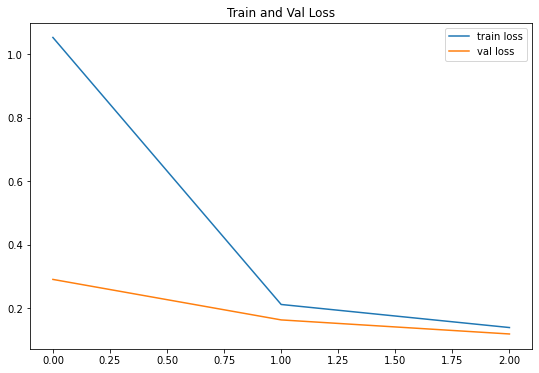

In [ ]:
# loss curve
fig = plt.figure(figsize=(9, 6))
plt.plot(model_loss['train'], label='train loss')
plt.plot(model_loss['val'], label='val loss')
plt.title("Train and Val Loss")
plt.legend()
plt.show()

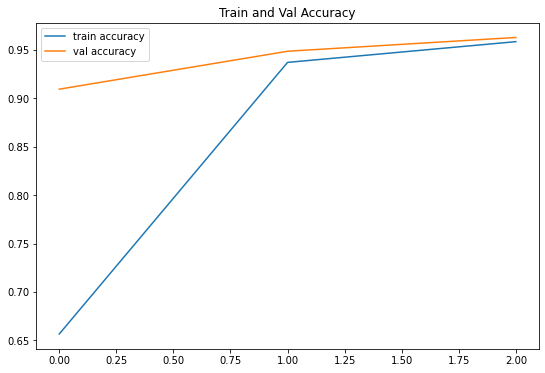

In [ ]:
# accuracy curve
fig = plt.figure(figsize=(9, 6))
plt.plot(model_acc['train'], label='train accuracy')
plt.plot(model_acc['val'], label='val accuracy')
plt.title("Train and Val Accuracy")
plt.legend()
plt.show()

# 預測

In [ ]:
model = torch.load("/content/drive/MyDrive/Colab Notebooks/GSDC/checkpoint/2_0.9628333333333333.pth")

In [ ]:
def test(testloader, model, criterion):
    model.eval()
    y_pred = []   #保存預測label
    y_true = []   #保存實際label 
    pred = []
    with torch.no_grad():   
      for images, target in testloader:
        # images, target = images.to(device), target.to(device, dtype=torch.long)
        images = images.to(device)
        target = target.to(device, dtype=torch.long)
        output = model(images)
        _, preds = torch.max(output.data, 1) 
        
        pred.append(preds.item())    
        
        # loss = criterion(output, target)      
        y_pred.extend(preds.view(-1).numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
        y_true.extend(target.view(-1).numpy())      # target是ground-truth的label
        
    return y_pred, y_true, pred

In [ ]:
y_pred, y_true, pred = test(testloader, model, criterion)

## 成果展示

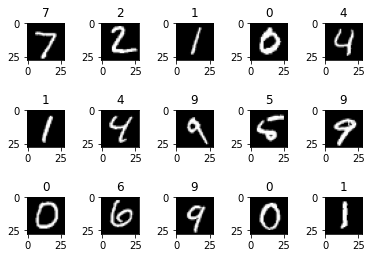

In [ ]:
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(testset.data[i].numpy(), cmap = 'gray')
  plt.title(str(pred[i]))
  # plt.pause(0.5)
  plt.subplots_adjust(wspace=1.0, hspace=1.0) # matplotlib.pyplot.subplots_adjust: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
plt.show()

## Confusion Matrix

In [ ]:
# 製作混淆矩陣
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)    

Text(60.0, 0.5, 'label (ground truth)')

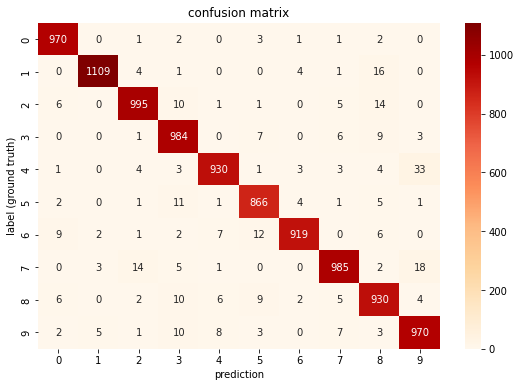

In [ ]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(cf_matrix)     
plt.figure(figsize = (9,6))
plt.title('confusion matrix')
sns.heatmap(df_cm, annot=True, fmt="d", cmap='OrRd')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

# HW - [CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

![image.png](https://i.imgur.com/FWmGcD9.png)

Use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

* Load CIFAR-10 資料進來(類別數不同)
* Augmentation Skills 更多元
* Model Design